In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
variants_file = "/data5/deepro/ukbiobank/papers/bmi_project/1_parse_data/annotate_vcf/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
combinations2_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv"
combinations3_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"

In [3]:
variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)
combinations2_df = pd.read_csv(combinations2_file, low_memory=False)
combinations3_df = pd.read_csv(combinations3_file, low_memory=False)
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})

In [4]:
# get all single genes
def get_unique_genes_from_combo_df(combo_df, ncombos):
    gene_set = set()
    for i in range(1, ncombos+1):
        gene_set.update(list(combo_df[f"Item_{i}_symbol"]))
    return gene_set


def get_samples_with_hits(variants_df, gene_set):
    return set(variants_df.loc[variants_df.SYMBOL.isin(gene_set)].Sample)

def check_combo_func(gene_list, combo_list):
    for combo in combo_list:
        if all(gene in gene_list for gene in combo):
            return True
    return False

def get_single_combo_phenos(variants_df, phenotypes_df, combinations_df, ncombos, ):
    # get unique genes in combos
    gene_set = get_unique_genes_from_combo_df(combinations_df, 2)
    # sort combos by their gene names for consistency of pipeline
    all_combos_sorted = sorted(map(lambda x: tuple(sorted(x)), zip(*[combinations_df[f"Item_{c}_symbol"].to_list() for c in range(1, ncombos+1)])))
    # store gene to their combo mappings
    gene_to_combo_map ={g:[] for g in gene_set}
    for g in gene_set:
        for c in all_combos_sorted:
            if g in c:
                gene_to_combo_map[g].append(c)
    # get samples with a single hit of the gene and those with combinations
    all_accepted_samples = set()
    all_rejected_samples = set()
    for g in gene_set:
        # select samples with variants in those genes
        samples_list = variants_df.loc[variants_df.SYMBOL.isin([g])].Sample
        samples_df = variants_df.loc[variants_df.Sample.isin(samples_list)].groupby("Sample").aggregate(lambda x: list(x))
        # exclude samples which have the combinations for these genes
        rejected_series = samples_df.SYMBOL.apply(check_combo_func, args=(gene_to_combo_map[g], )) 
        rejected_samples = samples_df.loc[rejected_series].index.to_list()
        accepted_samples = samples_df.loc[~rejected_series].index.to_list()
        all_accepted_samples.update(accepted_samples)
        all_rejected_samples.update(rejected_samples)
    # get rid of samples with other combo hits from single gene hits
    all_accepted_samples =  all_accepted_samples - all_rejected_samples
    single_hit_pheno = phenotypes_df.loc[phenotypes_df.eid.isin(all_accepted_samples)]
    combo_hit_pheno = phenotypes_df.loc[phenotypes_df.eid.isin(all_rejected_samples)]
    return single_hit_pheno, combo_hit_pheno

In [5]:
single_hit_pheno_c2, combo_hit_pheno_c2 = get_single_combo_phenos(variants_df, phenotypes_df, combinations2_df, 2)
single_hit_pheno_c3, combo_hit_pheno_c3 = get_single_combo_phenos(variants_df, phenotypes_df, combinations3_df, 3)

# Violin plot

In [6]:
single_hit_pheno_c2["vtype"] = "Single hit"
combo_hit_pheno_c2["vtype"] = "Combo hit"
single_hit_pheno_c2["ncombo"] = "Digenic"
combo_hit_pheno_c2["ncombo"] = "Digenic"

single_hit_pheno_c3["vtype"] = "Single hit"
combo_hit_pheno_c3["vtype"] = "Combo hit"
single_hit_pheno_c3["ncombo"] = "Trigenic"
combo_hit_pheno_c3["ncombo"] = "Trigenic"

/tmp/ipykernel_4058640/905299485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hit_pheno_c2["vtype"] = "Single hit"
/tmp/ipykernel_4058640/905299485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_hit_pheno_c2["vtype"] = "Combo hit"
/tmp/ipykernel_4058640/905299485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [7]:
violin_df = pd.concat((single_hit_pheno_c2, combo_hit_pheno_c2, single_hit_pheno_c3, combo_hit_pheno_c3), axis=0)

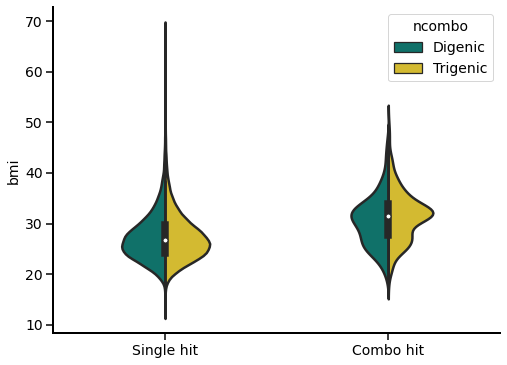

In [22]:
fig = plt.figure(figsize=(8,6))
sns_ax = sns.violinplot(
    data=violin_df, x="vtype", y="bmi", 
    hue="ncombo", split=True,
    width=0.4, linewidth=2.5,
    palette=["#008176", "#eecc16"],  # "#eecc16", "#c1272d"
    hue_order= ["Digenic", "Trigenic"],
    )

ax = plt.gca()
sns_ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)


/tmp/ipykernel_4012371/1314108267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hit_pheno_c2["vtype"] = "single_hit"
/tmp/ipykernel_4012371/1314108267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_hit_pheno_c2["vtype"] = "combo_hit"


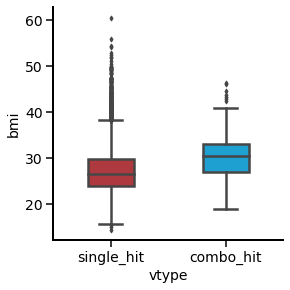

In [6]:
boxdf = pd.concat((single_hit_pheno_c2, combo_hit_pheno_c2), axis=0)

# Box Plot
sns_ax = sns.catplot(
    data=boxdf,
    palette=["#c1272d", "#00ADEE"],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    kind="box",
    x="vtype",
    y="bmi",
    orient="v",
    height=4,
    aspect=1,
    width=0.4,
    linewidth=2.5,
    fliersize=3.5
    )

/tmp/ipykernel_4012371/3610404233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hit_pheno_c3["vtype"] = "single_hit"
/tmp/ipykernel_4012371/3610404233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_hit_pheno_c3["vtype"] = "combo_hit"


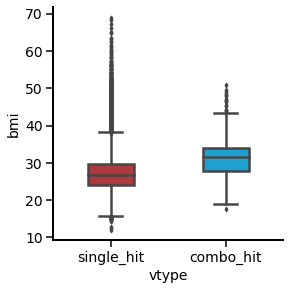

In [7]:
boxdf = pd.concat((single_hit_pheno_c3, combo_hit_pheno_c3), axis=0)
# # Define Canvas
# fig,ax = plt.subplots(1, 1, figsize=(8, 8))

# Box Plot
sns_ax = sns.catplot(
    data=boxdf,
    palette=["#c1272d", "#00ADEE"],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    kind="box",
    x="vtype",
    y="bmi",
    orient="v",
    height=4,
    aspect=1,
    width=0.4,
    linewidth=2.5,
    fliersize=3.5
    )

In [8]:
ttest_ind(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi, alternative="less"), kstest(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi)

(Ttest_indResult(statistic=-10.400470428015863, pvalue=1.4621164126916534e-25),
 KstestResult(statistic=0.32861802904881665, pvalue=8.849310932759738e-24))

In [9]:
ttest_ind(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi, alternative="less"), kstest(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi)

(Ttest_indResult(statistic=-26.510898062286397, pvalue=8.810889200687164e-155),
 KstestResult(statistic=0.4330296110581548, pvalue=2.5767301611682205e-149))